<a href="https://colab.research.google.com/github/dbenayoun/IASD/blob/main/ProjetIA/ADV2_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cuda = torch.cuda.is_available()

## Moving to neural networks

Now that we've seen how adversarial examples work in the context of linear models, let's move to the setting we really care about: the possibility of adversarial examples in deep neural networks.

First, let us define formally a neural network. Let us define $h_\theta(x) : \mathbb{R}^n \rightarrow \mathbb{R}^k$ to be an $d$-layer network, given by the following equations
\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}
where $z_i$ denote the activations at layer $i$; $f_i$ denotes the activation function for layer $i$, which we will often take to be e.g. the ReLU operator $f_i(z) = \max\{0,z\}$ for layers $i=1,\ldots,d-1$ and the linear operator $f_i(z) = z$ for layer $d$ (remember, the last layer outputs are the class logits, and the loss function "builds in" the softmax operator, so we don't explicitly put the softmax into the network); and the parameters of the network are given by $\theta = \{W_1,b_1,\ldots,W_d,b_d\}$ (in the above, $W_i$ is most obviously interpreted a matrix, but it could really be any linear operator including convolutions).  We won't worry for now about explicitly defining the size of all the intermediate layers, but we assume that they are specified such that the final function $h_\theta$ takes inputs in $\mathbb{R}^n$ and outputs vectors in $\mathbb{R}^k$.  The loss function for multiclass case, namely the Cross Entropy loss, is as follows:
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y.
\end{equation}

## Crafting an attack

Unlike it the linear case, it is _not_ easy to solve, the maximization problem over our perturbation. This is because the cost surface for neural networks (here considering it over the _input_ space, not parameter space) is not convex, and is especially prone to local optima.  We can see this even in the simple example above, where there are local optimal when either trying to maximize or minimize the function above, and the initial gradient at a given point may or may not point in the direction of the actual maxima.

So how _do_ we go about (approximately) solving the inner optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y)
\end{equation}
in the case of $h_\theta$ being a neural network?

The most common strategy to approximate the pertubation is to find a _lower bound_ on the optimization objective.  Because (by definition) _any_ feasible $\delta$ will give us a lower bound, this is equivalent to just "trying to empirically solve the optimization problem", i.e., "find an adversarial example."  
This is by far the most common strategy for solving the inner maximization motivated largely by the fact that for neural networks in general, problems of local optima don't seem as bad as initially may be thought.

## Lower bounding the inner maximization (i.e., adversarial attacks)

Let's start by considering perhaps the simplest way of solving the optimization problem we care about, the task of maximizing
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
In fact we already saw one example for how to do this in our introductory lecture, but the basic idea here is quite simple: using backpropagation, we can compute the gradient of the loss function with respect to the perturbation $\delta$ itself, so let's just perform gradient descent on $\delta$ to maximize our objective.  However, we also need to ensure that $\delta$ stays within the norm bound $\epsilon$, so after each step, we can project back into this space.



### The Fast Gradient Sign Method (FGSM)

Let's consider in a bit more detail how we might do the attack we mentioned above.  For some given example $x$, we know that we are going to adjust $\delta$ in the direction of it's gradient, i.e., we will first compute the gradient
\begin{equation}
g := \nabla_\delta \ell(h_\theta(x + \delta),y)
\end{equation}
using simple backpropagation; note that if we're evaluating this gradient at $\delta=0$ (as we would at the first timestep), then this is also just equal to $\nabla_x \ell(h_\theta(x),y)$, but we'll express the gradients in terms of $\delta$ to be consistent with how we do things going forward.

In order to maximize loss, we want to adjust delta in the direction of this gradient, i.e., take a step
\begin{equation}
\delta := \delta + \alpha g
\end{equation}
for some step size $\alpha$ and then project back into the norm ball defined by $\|\delta\| \leq \epsilon$.  But how big a step do we take?  For concreteness, let's consider the particular case of the $\ell_\infty$ norm $\|\delta\|_\infty \leq \epsilon$, where, as we mentioned before, projecting onto this norm ball simply involves clipping values of $\delta$ to lie within the range $[-\epsilon, \epsilon]$.  If our initial $\delta$ is zero, this gives the update
\begin{equation}
\delta := \mathrm{clip}(\alpha g, [-\epsilon, \epsilon]).
\end{equation}
Now, how big of a step size should we take?  If we want to make increase the loss as much as possible, it makes sense to take as large a step as possible, i.e., take $\alpha$ to be very large (of course knowing that we won't take _that_ big a step, since we're projecting back into the $\ell_\infty$ ball afterwards).  It is not hard to see that for $\alpha$ large enough, the relative sizes of the entries of $g$ won't matter: we will simply take $\delta_i$ to be either $+\epsilon$ or $-\epsilon$ depending upon the sign of $g_i$.  In other words, for large $\alpha$, this update becomes
\begin{equation}
\delta := \epsilon \cdot \mathrm{sign}(g).
\end{equation}

This is know as the Fast Gradient Sign Method (FGSM) [1], and it was one of the first methods for constructing adversarial examples proposed by the deep learning community.

[1] Explaining and Harnessing Adversarial Examples

### Exercice 2
1. Define a neural network with 2 convolutional layers and 3 fully connected layers
2. Train the network on the full CIFAR10 Dataset
3. Code the FGSM attack
4. Evaluate your model against FGSM
5. Plot some images with and without the adversarial perturbation
6. Make an analysis of FGSM attack and compare it with the attack from the first notebook

In [2]:
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10("./docs", train=train, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

batch_size = 100
train_loader = load_cifar('train', batch_size)
test_loader = load_cifar('test', batch_size)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Extracting ./docs/cifar-10-python.tar.gz to ./docs
Files already downloaded and verified


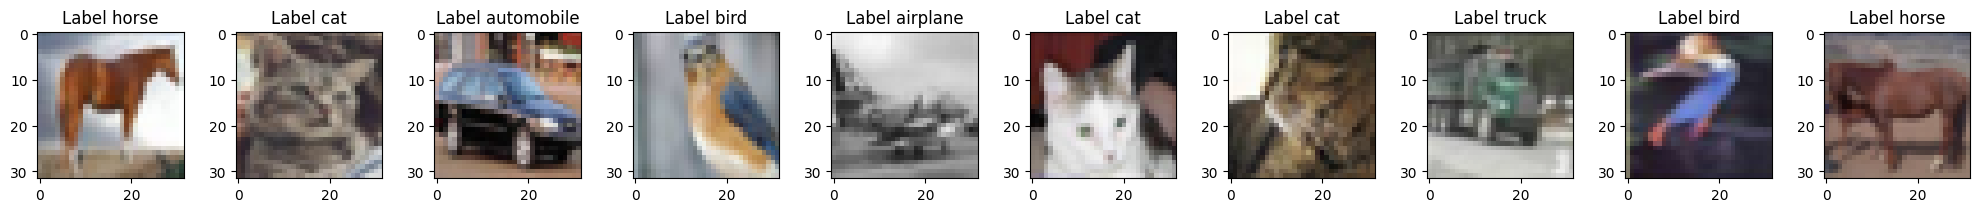

In [3]:
plt.figure(figsize=(20, 2))
imgs, labels = next(iter(train_loader))
for k in range(10):
    plt.subplot(1, 10, k+1)
    plt.imshow(imgs[k].reshape(3, 32, 32).numpy().transpose(1, 2, 0), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Label {cifar10_classes[int(labels[k].item())]}')
plt.tight_layout()

In [4]:
def train_model(model, criterion, optimizer, loader, epochs=10):
  """Function to train the model"""
  # train your model
  for epoch in range(epochs):
    for batch_n, (imgs, labels) in enumerate(loader):
      if cuda:
        imgs, labels = imgs.cuda(), labels.cuda()
      optimizer.zero_grad()
      outputs = model(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    print('epoch {}, loss: {:.4f}'.format(epoch, loss))

In [5]:
# convolutional model with 2 convolution, 2 max pooling layer, 3 fully connected layer
# the model should be: 2x (conv -> max pooling -> relu) -> 2x (fc -> relu) -> fc

class Flatten(torch.nn.Module):
  def forward(self, x):
    shape = x.shape
    return x.reshape(shape[0], x.shape[1]*x.shape[2]*x.shape[3])

class ConvModel(torch.nn.Module):

  def __init__(self):
    super(ConvModel, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=3,
                                 out_channels=6,
                                 kernel_size=3,
                                 padding=1)

    self.conv2 = torch.nn.Conv2d(in_channels=6,
                                 out_channels=16,
                                 kernel_size=3,
                                 padding=1)

    self.max_pooling = torch.nn.MaxPool2d(2)
    self.conv2 = torch.nn.Conv2d(6, 16, 3, padding=1)
    self.linear1 = torch.nn.Linear(1024, 120)
    self.linear2 = torch.nn.Linear(120, 84)
    self.linear3 = torch.nn.Linear(84, 10)
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    out = self.conv1(x) #dim 6x32x32
    out = self.relu(out)
    out = self.max_pooling(out) #dim 6x16x16
    out = self.conv2(out) #dim 16x16x16
    out = self.relu(out)
    out = self.max_pooling(out) #dim 16x8x8
    out = out.view(-1, 1024)
    out = self.linear1(out) #dim 1024
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    return self.linear3(out)

In [6]:
model = ConvModel()
if cuda:
  model = model.cuda()

In [7]:
cuda

True

In [8]:
list(np.prod(x.shape) for x in model.parameters())

[162, 6, 864, 16, 122880, 120, 10080, 84, 840, 10]

In [9]:
# define your loss function
criterion = torch.nn.CrossEntropyLoss()

# define your optimizer
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

train_model(model, criterion, opt, train_loader, 3)

epoch 0, loss: 1.8327
epoch 1, loss: 1.6643
epoch 2, loss: 1.3286


In [10]:
def eval_model(model, loader, attack=None):
  """Function to evaluate your model on a specific loader"""
  accuracy = 0.
  n_inputs = 0.
  for n_batch, (imgs, labels) in enumerate(loader):
    if cuda:
      imgs, labels = imgs.cuda(), labels.cuda()
    if attack is None:
      outputs = model(imgs)
    else:
      delta = attack.compute(imgs, labels)
      adv = (imgs + delta).clamp(0, 1)
      outputs = model(adv)

    _, predicted = torch.max(outputs.data, 1)
    accuracy += predicted.eq(labels.data).cpu().sum().numpy()
    n_inputs += imgs.shape[0]
  accuracy /= n_inputs
  print('accuracy on testset: {:.4f}'.format(accuracy))

eval_model(model, test_loader)

accuracy on testset: 0.5036


In [11]:
class FastGradientSignMethod:

  def __init__(self, model, eps):
    self.model = model
    self.eps = eps

  def compute(self, x, y):
    """ Construct FGSM adversarial perturbation for examples x"""
    delta = torch.zeros_like(x, requires_grad=True)
    loss = nn.CrossEntropyLoss()(self.model(x + delta), y)
    loss.backward()
    return self.eps * delta.grad.detach().sign()

fgsm = FastGradientSignMethod(model, 0.03)
eval_model(model, test_loader, fgsm)

accuracy on testset: 0.0891


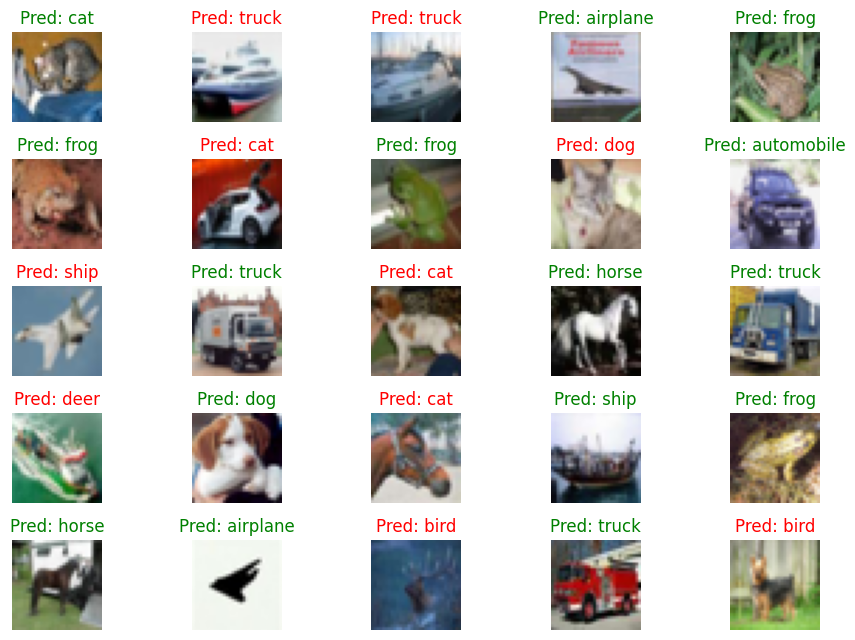

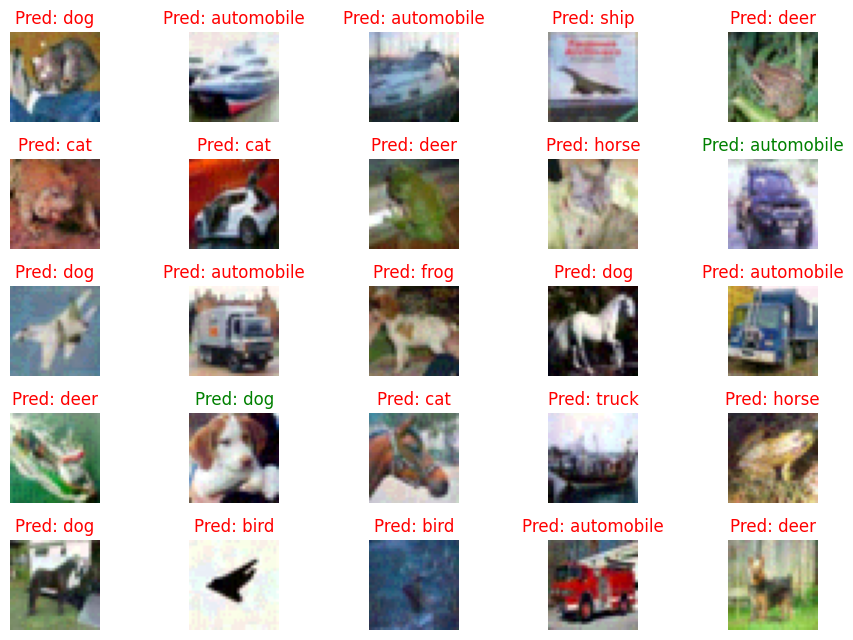

In [12]:
def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N*2, M*1.3))
  for i in range(M):
    for j in range(N):
      img = x[i*N+j].transpose(1, 2, 0)
      img = np.maximum(0, np.minimum(img, 1))
      ax[i][j].imshow(img)
      title = ax[i][j].set_title("Pred: {}".format(cifar10_classes[int(yp[i*N+j].max(dim=0)[1])]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()

for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break

# plot natural images
output = model(imgs)
plot_images(imgs, labels, output)

# plot adversarial images
delta = fgsm.compute(imgs, labels)
output = model(imgs + delta)
plot_images(imgs + delta, labels, output)

### Projected gradient descent

This discussion immediately brings us to the next approach we would want to consider for maximizing the optimization problem, just doing projected gradient descent (i.e., the above procedure, but iterating it and with a smaller step size). [Note: technically speaking, this is gradient _ascent_ since we are maximizing a function rather than minimization, but it's common to just refer to the process as gradient descent.]. This was also called the "basic iterative procedure" in it's first appearance within the adversarial attacks literature [1], but essentially it is just the obvious choice for how we might maximize the inner objective a bit more carefully than with FGSM. The basic PGD algorithm simply iterates the updates:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \delta := \mathcal{P}(\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y))
\end{split}
\end{equation}
where $\mathcal{P}$ denotes the projection onto the ball of interest (for example, clipping in the case of the $\ell_\infty$ norm).  Of course, with PGD we now have more choices we need to make when specifying the attack, such as the actual stepsize itself, and the number of iterations (we'll discuss some rules of thumb shortly once we present a slightly modified version of the above iteration).  We can implement this attack in the following manner, where we're here going to implement the gradient descent procedure rather than rely on one of PyTorch's optimizers, as we want to see what's going on a bit more explicitly (PyTorch's SGD also includes terms like momentum, which actually usually are able to optimize the inner term _better_, but we want to have as little black-box procedures here as possible).

[1] Adversarial Machine Learning At Scale

In [13]:
class ProjectedGradientDescent:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha
    self.num_iter = num_iter

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    # delta = torch.randn_like(x, requires_grad=True)
    delta = torch.zeros_like(x, requires_grad=True)
    for t in range(self.num_iter):
      adv = torch.clamp(x + delta, 0, 1)
      loss = nn.CrossEntropyLoss()(self.model(adv), y)
      loss.backward()
      delta.data = (delta.data + self.alpha * delta.grad.sign()).clamp(-self.eps, self.eps)
      delta.grad.zero_()
    return delta.detach()


pgd = ProjectedGradientDescent(model, 0.03, 0.006, 20)
eval_model(model, test_loader, pgd)

accuracy on testset: 0.0510


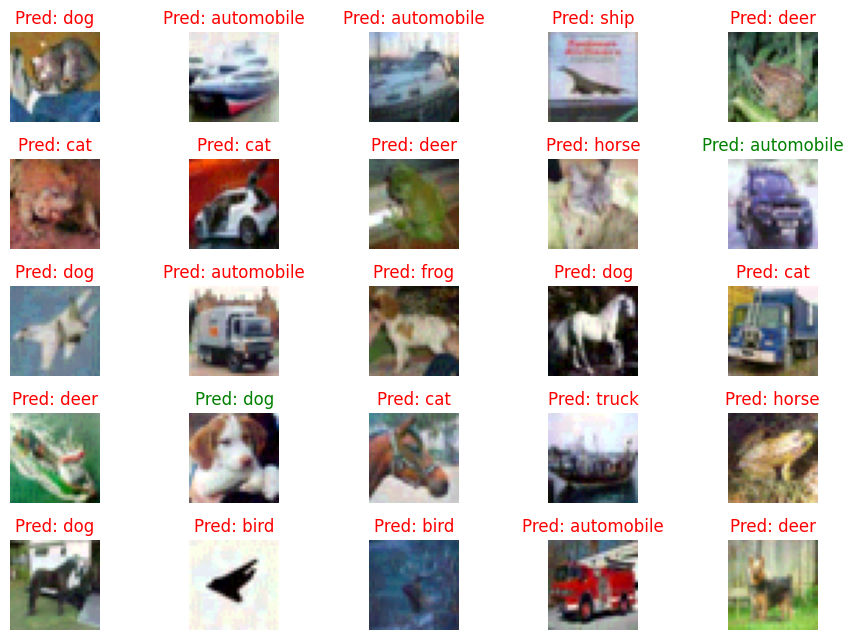

In [14]:
pgd = ProjectedGradientDescent(model, 0.03, 0.006, 20)
delta = pgd.compute(imgs, labels)
output = model(imgs + delta)
plot_images(imgs+delta, labels, output)

alpha 0.075 eps 0.15 nb_iter 20
accuracy on testset: 0.0632


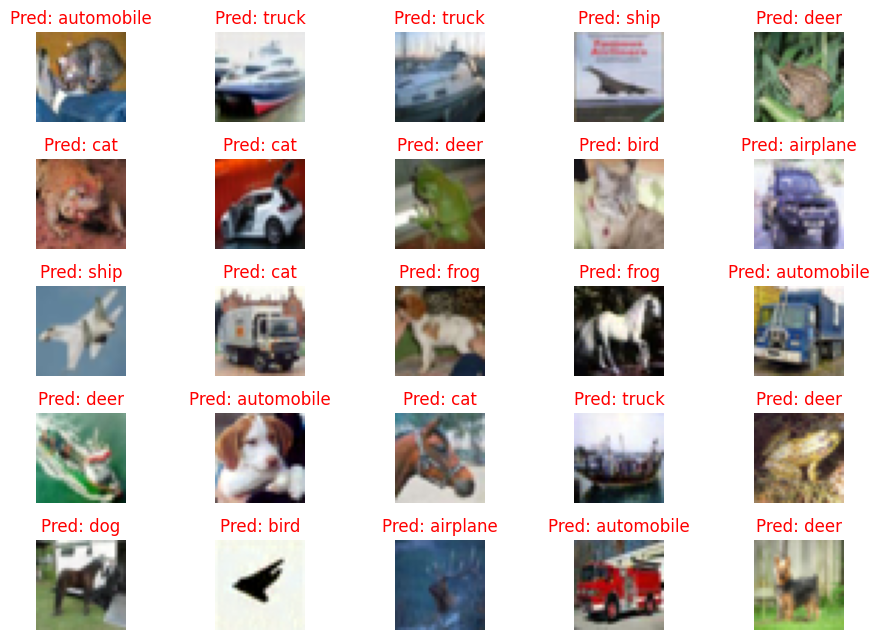

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

class ProjectedGradientDescentL2:
    """
    Implements the Projected Gradient Descent (PGD) attack in L2 norm for adversarial example generation.

    Attributes:
        model (torch.nn.Module): The model to attack.
        eps (float): Maximum perturbation (L2 norm bound).
        alpha (float): Step size for each iteration.
        num_iter (int): Number of iterations for the attack.
    """
    def __init__(self, model, eps, alpha, num_iter):
        """
        Initializes the PGD attack.

        Args:
            model (torch.nn.Module): The model to attack.
            eps (float): Maximum L2 norm of the perturbation.
            alpha (float): Step size for the attack.
            num_iter (int): Number of attack iterations.
        """
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.num_iter = num_iter

    def compute(self, x, y):
        """
        Generates an adversarial perturbation using PGD with L2 norm.

        Args:
            x (torch.Tensor): Original input images.
            y (torch.Tensor): True labels for the input images.

        Returns:
            torch.Tensor: The computed adversarial perturbations.
        """
        # initialize the perturbation delta to zero, and require gradient for optimization
        delta = torch.zeros_like(x, requires_grad=True)

        # iteratively compute adversarial perturbations
        for t in range(self.num_iter):
            # add perturbation to the input and clamp values between [0, 1]
            adv = x + delta
            adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0,1]

            # get model output and compute loss (cross-entropy)
            output = self.model(adv)
            loss = nn.CrossEntropyLoss()(output, y)

            # create a mask to ignore correctly classified samples
            mask = 1 * (torch.max(output, 1)[1] == y)

            # backpropagate the loss to get gradients w.r.t delta
            loss.backward()

            # compute the L2 norm of the gradient
            grad_norm = torch.norm(delta.grad.detach(), p=2, dim=[1, 2, 3])

            # normalize the gradient for L2 projection
            normalized_grad = delta.grad.detach() / (grad_norm.view(-1, 1, 1, 1) + 1e-10)

            # update delta using gradient ascent while applying the mask for correct classifications
            delta.data += self.alpha * normalized_grad * mask.view(-1, 1, 1, 1)

            # reshape delta for renormalization
            shape_perturb = delta.data.shape

            # apply L2 projection to ensure perturbation is within the epsilon ball
            delta.data = torch.renorm(delta.detach().reshape(delta.size(0), -1), p=2, dim=1, maxnorm=self.eps)
            delta.data = delta.data.reshape(*shape_perturb)

            # ensure the final perturbation keeps the adversarial example within valid pixel range [0, 1]
            delta.data = torch.clamp(x.data + delta.data, 0, 1) - x.data

            # zero out the gradients for the next iteration
            delta.grad.zero_()

        # Return the computed adversarial perturbation
        return delta.detach()

eps = 0.14
eps = 0.15
nb_iter = 20
alpha = (eps / nb_iter) *10
print("alpha", alpha, "eps", eps, "nb_iter", nb_iter)
model = model.cuda()
pgdl2 = ProjectedGradientDescentL2(model, eps, alpha, nb_iter)
eval_model(model, test_loader, pgdl2)

delta = pgdl2.compute(imgs, labels)
output = model(imgs + delta)
plot_images(imgs+delta, labels, output)

In [ ]:
pgd = ProjectedGradientDescentl2(model, 0.03, 0.006, 20)
delta = pgd.compute(imgs, labels)
output = model(imgs + delta)
plot_images(imgs+delta, labels, output)

### Test you attacks on real world images

let's use the (pre-trained) ResNet50 model within PyTorch to classify this picture of a pig.

['Pig'](docs/pig.jpg)



In [ ]:
!wget https://www.lamsade.dauphine.fr/~averine/ProjetIA/pig.jpg -P docs
!wget https://www.lamsade.dauphine.fr/~averine/ProjetIA/imagenet_class_index.json -P docs

--2024-09-10 15:28:09--  https://www.lamsade.dauphine.fr/~averine/ProjetIA/pig.jpg
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56267 (55K) [image/jpeg]
Saving to: ‘docs/pig.jpg.1’

pig.jpg.1           100%[===================>]  54.95K  --.-KB/s    in 0.02s   

2024-09-10 15:28:09 (2.22 MB/s) - ‘docs/pig.jpg.1’ saved [56267/56267]

--2024-09-10 15:28:09--  https://www.lamsade.dauphine.fr/~averine/ProjetIA/imagenet_class_index.json
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘docs/imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.

In [ ]:
!pwd

/content


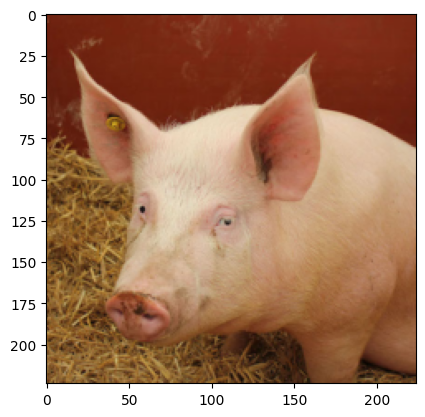

In [ ]:
# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("docs/pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.show()

In [ ]:
from torchvision.models import resnet50

class NormModel(nn.Module):
  def __init__(self, model):
      super(NormModel, self).__init__()
      self.model = model
      self.norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  def forward(self, x):
      return self.model(self.norm(x))
# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
# norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = NormModel(resnet50(pretrained=True))
model.eval();

In [ ]:
# form predictions
pred = model(pig_tensor)
print(torch.argmax(pred))
with open("docs/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

tensor(341)
hog


Pred now contains a 1000 dimensional vector containing the class logits for the 1000 imagenet classes (i.e., if you wanted to convert this to a probability vector, you would apply the softmax operator to this vector).  To find the highest likelihood class, we simply take the index of maximum value in this vector, and we can look this up in a list of imagenet classes to find the corresponding label.

In [ ]:
class NormModel(nn.Module):

  def __init__(self, model):
      super(NormModel, self).__init__()
      self.model = model
      self.norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  def forward(self, x):
      return self.model(self.norm(x))

tensor(470)
candle


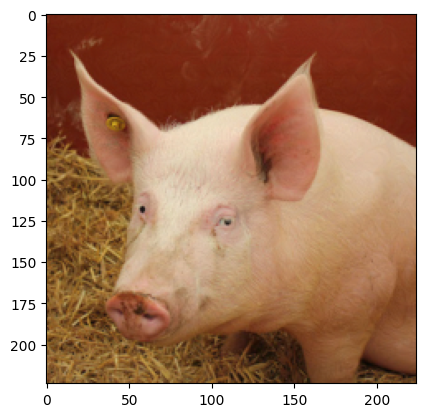

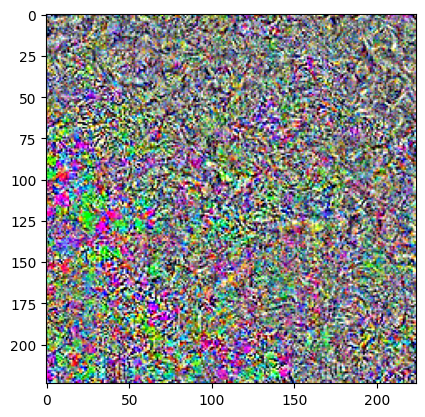

In [ ]:
# Perform an attack on the image and plot the pertubation

pgd = ProjectedGradientDescent(model, 0.03, 0.04/20, 5)

label = torch.LongTensor([pred.max(dim=1)[1].item()])
delta = pgd.compute(pig_tensor, label)
adv = torch.clamp(pig_tensor + delta, 0, 1)

print(model(adv).argmax())
print(imagenet_classes[int(model(adv).argmax().item())])
plt.imshow((adv)[0].detach().numpy().transpose(1,2,0))
plt.show()

plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
plt.show()

tensor(341)
hog


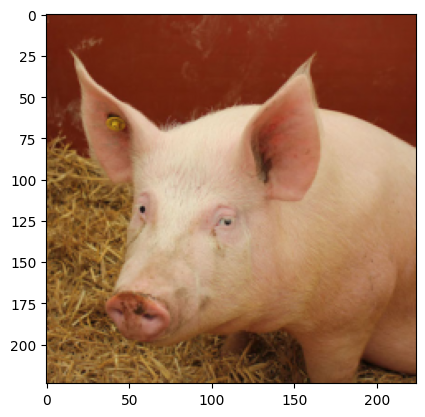

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class ProjectedGradientDescentL2:

    def __init__(self, model, eps, alpha, num_iter):
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.num_iter = num_iter

    def compute(self, x, y):
        delta = torch.zeros_like(x, requires_grad=True)
        for t in range(self.num_iter):
            adv = x + delta
            adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0,1]
            loss = nn.CrossEntropyLoss()(self.model(adv), y)
            loss.backward()
            grad_norm = delta.grad.detach().norm(2)
            normalized_grad = delta.grad.detach() / (grad_norm + 1e-10)
            delta.data += self.alpha * normalized_grad
            delta.data = torch.renorm(delta.detach(), p=2, dim=0, maxnorm=self.eps)
            delta.grad.zero_()
        return delta.detach()

# Assuming model, pig_tensor, pred, and imagenet_classes are defined
eps = 10.0
pgd = ProjectedGradientDescentL2(model, 10, 0.04 / 20, 5)

label = torch.LongTensor([pred.max(dim=1)[1].item()])
delta = pgd.compute(pig_tensor, label)
adv = pig_tensor + delta
adv = torch.clamp(adv, 0, 1)  # Ensure the values are in [0,1]

print(model(adv).argmax())
print(imagenet_classes[int(model(adv).argmax().item())])

plt.imshow((adv)[0].detach().numpy().transpose(1, 2, 0))
plt.show()

torch.Size([1, 3, 224, 224])


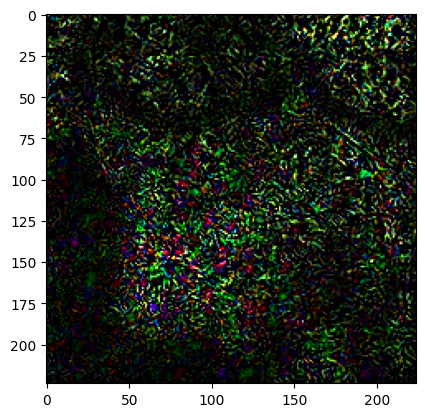

In [ ]:
print(delta.shape)
plt.imshow((10000 * delta )[0].detach().numpy().transpose(1, 2, 0))
plt.show()